## Variational Quantum Eigensolver (VQE) Implementation


## Core Components of VQE

VQE is a hybrid quantum-classical algorithm that consists of three essential ingredients:

### 1. Ansatz ($U_A(\theta)$)

An educated guess of the solution to the problem
A trial quantum state defined by a quantum circuit with tunable parameters
Consists of:

Reference Preparation ($U_R$): Initial state preparation
Variational Form ($U_V(\theta_i)$): Parameterized quantum operations



### 2. Cost Function ($C(\theta)$)

Quantifies the quality of the Ansatz for a particular set of parameters
Calculates the eigenvalue of the observable with respect to a particular quantum state
Measured through multiple shots on quantum hardware

### 3. Classical Optimizer

Iteratively updates the Ansatz parameters based on the feedback provided by the cost evaluations
Navigates the Ansatz parameter space to converge at the lowest possible cost
Uses classical optimization techniques like COBYLA or SPSA

<br>

## Optimization Loop
The VQE algorithm follows an iterative optimization process:

Bootstrap: Initialize parameters $\theta_i$
Quantum Stage:

Prepare reference state ($U_R$)
Apply variational form ($U_V(\theta_i)$)
Perform measurements


Classical Stage:

Evaluate cost function $C(\theta_i)$
Run optimization to determine next parameters $\theta_{i+1}$


Repeat until convergence

<br> 

## Required Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit_nature import settings
from qiskit_aer import AerSimulator
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_algorithms.optimizers import COBYLA
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, EstimatorV1 as Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
settings.use_pauli_sum_op = False
from token_file import token

## Implementation Components

### Molecule Configuration

In [3]:
def get_qubit_op(dist):
    """
    Creates a molecular Hamiltonian for H2 molecule at specified interatomic distance.
    This Hamiltonian encodes the electronic structure problem we aim to solve.
    The ground state energy of this Hamiltonian represents the molecule's lowest energy state.
    
    Args:
        dist (float): Interatomic distance in Bohr
        
    Returns:
        tuple: (qubit_op, num_particles, num_spatial_orbitals, problem, mapper)
    """
    molecule = MoleculeInfo(
        symbols = ["H", "H"],
        coords = ([0,0,0], [0,0,dist]),
        multiplicity=1,
        charge=0,
        units=DistanceUnit.BOHR
    )
    driver = PySCFDriver.from_molecule(molecule)
    problem = driver.run()
    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals
    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

### Ansatz Construction

In [4]:
def create_ansatz(num_spatial_orbitals, num_particles, mapper):
    reference_state = HartreeFock(
        num_spatial_orbitals,
        num_particles,
        mapper
    )
    var_form = UCCSD(
        num_spatial_orbitals=num_spatial_orbitals,
        num_particles=num_particles,
        qubit_mapper=mapper,
        initial_state=reference_state,
    )
    return var_form

### Execution

In [5]:
# backend selection

def setup_quantum_backend(service):
    backend = service.least_busy(
        min_num_qubits=1,
        operational=True,
        simulator=True
    )
    return backend

In [6]:
# VQE Routine

def run_vqe(qubit_op, var_form, estimator, optimizer=None):
    if optimizer is None:
        optimizer = COBYLA(maxiter=20)
    
    vqe_solver = VQE(estimator=estimator,
                     ansatz=var_form,
                     optimizer=optimizer)
    
    result = vqe_solver.compute_minimum_eigenvalue(qubit_op)
    return result

## Error Mitigation
For real quantum hardware execution:

Set resilience_level=2 for zero-noise extrapolation
Use optimized circuit transpilation
Monitor error rates and gate counts

### Visualization Functions

In [7]:
def plot_energy_landscape(energies, distances):
    plt.figure(figsize=(10, 6))
    plt.plot(distances, energies, 'o-')
    plt.xlabel('Interatomic Distance (Bohr)')
    plt.ylabel('Energy (Hartree)')
    plt.title('Ground State Energy vs. Interatomic Distance')
    plt.grid(True)
    plt.show()

In [8]:
# Configure problem
dist = 1.2
qubit_op, num_particles, num_spatial_orbitals, problem, mapper = get_qubit_op(dist)

# Create ansatz
var_form = create_ansatz(num_spatial_orbitals, num_particles, mapper)

# Setup backend
# Initialize service and backend
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
real_backend = service.backend('ibm_brisbane') 
sim_backend = AerSimulator.from_backend(real_backend)

with Session(backend=sim_backend) as session:
    estimator = Estimator(session=session, options={"resilience_level": 2})
    result = run_vqe(qubit_op, var_form, estimator)

print(f"Ground state energy: {result.eigenvalue.real:.6f} Hartree")

/tmp/ipykernel_135/453865374.py:15: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(session=session, options={"resilience_level": 2})


Ground state energy: -1.907538 Hartree


/tmp/ipykernel_135/4142971736.py:10: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  estimator = Estimator(session=session, options={"resilience_level": 2})


Distance: 0.500 Bohr, Energy: -1.536795 Hartree
Distance: 0.727 Bohr, Energy: -2.234612 Hartree
Distance: 0.955 Bohr, Energy: -2.093182 Hartree
Distance: 1.182 Bohr, Energy: -1.911826 Hartree
Distance: 1.409 Bohr, Energy: -1.842142 Hartree
Distance: 1.636 Bohr, Energy: -1.736746 Hartree
Distance: 1.864 Bohr, Energy: -1.634981 Hartree
Distance: 2.091 Bohr, Energy: -1.551868 Hartree
Distance: 2.318 Bohr, Energy: -1.477394 Hartree
Distance: 2.545 Bohr, Energy: -1.417654 Hartree
Distance: 2.773 Bohr, Energy: -1.353780 Hartree
Distance: 3.000 Bohr, Energy: -1.279207 Hartree


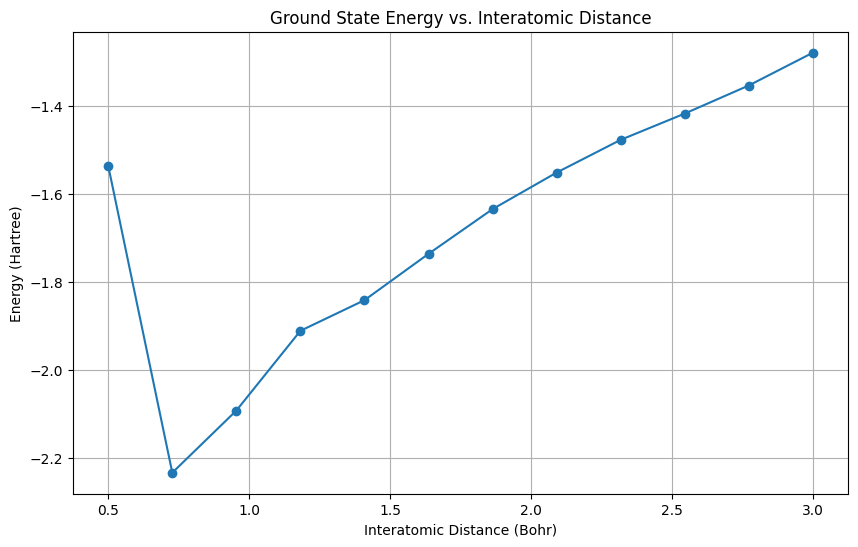

In [9]:
# Calculate energies for a range of distances
distances = np.linspace(0.5, 3, 12)  # 12 points between 0.5 and 3 Bohr
energies = []

service = QiskitRuntimeService(channel="ibm_quantum", token=token)
real_backend = service.backend('ibm_brisbane')
sim_backend = AerSimulator.from_backend(real_backend)

with Session(service=service, backend=sim_backend) as session:
    estimator = Estimator(session=session, options={"resilience_level": 2})
    
    for dist in distances:
        qubit_op, num_particles, num_spatial_orbitals, problem, mapper = get_qubit_op(dist)
        var_form = create_ansatz(num_spatial_orbitals, num_particles, mapper)
        result = run_vqe(qubit_op, var_form, estimator)
        energies.append(result.eigenvalue.real)
        print(f"Distance: {dist:.3f} Bohr, Energy: {result.eigenvalue.real:.6f} Hartree")

plot_energy_landscape(energies, distances)